## Observations and Insights 

#Look across all previously generated figures and tables and write at least three observations or inferences 
#that can be made from the data. Include these observations at the top of notebook.

Dependencies and data setup

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from itertools import cycle, islice
import seaborn as sns
from scipy.stats import linregress

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)
study_results = study_results.rename(columns={"Drug Regimen":"Drug_Regimen", "Tumor Volume (mm3)":"Tumor_Volume_mm3", "Mouse ID":"Mouse_ID"})
mouse_metadata = mouse_metadata.rename(columns={"Drug Regimen":"Drug_Regimen", "Mouse ID":"Mouse_ID"})

mouse_study_df = pd.merge(mouse_metadata, study_results)

mouse_study_df

,Mouse_ID,Drug_Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor_Volume_mm3,Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


Check for duplicate mouse ID numbers

In [2]:
# Checking the number of mice.
a = mouse_metadata["Mouse_ID"].nunique()
b = study_results["Mouse_ID"].nunique()
c = mouse_study_df["Mouse_ID"].nunique()
a, b, c

(249, 249, 249)

In [3]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
#https://stackoverflow.com/questions/29276958/identifying-duplicate-pairs-in-python-pandas
find_dup = mouse_study_df.groupby(['Mouse_ID', 'Timepoint']).size()                                 
find_dup = find_dup[find_dup > 1]
find_dup

Mouse_ID  Timepoint
g989      0            2
          5            2
          10           2
          15           2
          20           2
dtype: int64

In [4]:
# Optional: Get all the data for the duplicate mouse ID. 
# One copy of g989 seems to have died... will remove both of them, although maybe whoever collected the data
#knows the story
dup = mouse_study_df.loc[mouse_study_df['Mouse_ID'] == "g989"]
dup

,Mouse_ID,Drug_Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor_Volume_mm3,Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


Make clean dataframe

In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
mouse_study_clean_df = mouse_study_df[mouse_study_df["Mouse_ID"] != "g989"]
#mouse_study_clean_df.dtypes
mouse_study_clean_df

,Mouse_ID,Drug_Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor_Volume_mm3,Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [6]:
# Checking the number of mice in the clean DataFrame.
mouse_study_clean_df["Mouse_ID"].nunique()

248

Put placebo results first (for science)

In [7]:
#This seems harder than it should be, but none of the easier-looking suggestions I found did more than put the
#treatments in alphabetical order.

#https://stackoverflow.com/questions/43266211/sort-a-dataframe-based-on-values-of-another-column-using-\
#integer-data-type                                                     
#https://stackoverflow.com/questions/23279238/custom-sorting-with-pandas

drugs = mouse_study_clean_df.Drug_Regimen.unique()
#drugs
order = {'Placebo':0,'Ramicane':1, 'Capomulin':2, 'Infubinol':3,  'Ceftamin':4, 'Stelasyn':5, 'Zoniferol':6, 'Ketapril':7, 'Propriva':8, 'Naftisol':9}
mouse_study_clean_df.loc[:,'rank'] = mouse_study_clean_df.loc[:,'Drug_Regimen'].map(order)
mouse_study_clean_df = mouse_study_clean_df.iloc[mouse_study_clean_df.loc[:,'rank'].argsort()].dropna()
mouse_study_clean_df = mouse_study_clean_df.drop(labels=['rank'],axis=1)

mouse_study_clean_df.loc[:, "Age_months"] = pd.to_numeric(mouse_study_clean_df.loc[:, "Age_months"])
mouse_study_clean_df.loc[:,"Weight (g)"] = pd.to_numeric(mouse_study_clean_df.loc[:, "Weight (g)"])
mouse_study_clean_df.loc[:,"Timepoint"] = pd.to_numeric(mouse_study_clean_df.loc[:, "Timepoint"])
mouse_study_clean_df.loc[:,"Tumor_Volume_mm3"] = pd.to_numeric(mouse_study_clean_df.loc[:, "Tumor_Volume_mm3"])
mouse_study_clean_df.loc[:,"Metastatic Sites"] = pd.to_numeric(mouse_study_clean_df.loc[:,"Metastatic Sites"])

mouse_study_clean_df

#mouse_study_clean_df.dtypes

/Users/bmacgreg/opt/anaconda3/envs/NewPythonData/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/bmacgreg/opt/anaconda3/envs/NewPythonData/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Mouse_ID,Drug_Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor_Volume_mm3,Metastatic Sites
952,i477,Placebo,Female,3,30,10,47.520632,0
965,i669,Placebo,Female,18,27,10,48.281633,1
964,i669,Placebo,Female,18,27,5,46.764668,1
963,i669,Placebo,Female,18,27,0,45.000000,0
951,i477,Placebo,Female,3,30,5,46.657385,0
...,...,...,...,...,...,...,...,...
852,f993,Naftisol,Male,21,28,0,45.000000,0
853,f993,Naftisol,Male,21,28,5,46.395760,0
854,f993,Naftisol,Male,21,28,10,48.185373,0
1463,r604,Naftisol,Male,7,30,35,59.217000,2


## Summary Statistics

Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume 
for each regimen

This method is the most straighforward, creating multiple series and putting them all together at the end.

In [8]:
mice_by_drugs = mouse_study_clean_df.groupby("Drug_Regimen")
#drugs = mouse_study_clean_df.Drug_Regimen.unique()
#mice_by_drugs
mean = mice_by_drugs["Tumor_Volume_mm3"].mean()
median = mice_by_drugs["Tumor_Volume_mm3"].median()
variance = mice_by_drugs["Tumor_Volume_mm3"].var()
std = mice_by_drugs["Tumor_Volume_mm3"].std()
sem = mice_by_drugs["Tumor_Volume_mm3"].sem()

mouse_study_stats_df = pd.merge(mean, median, on=["Drug_Regimen"])
mouse_study_stats_df = mouse_study_stats_df.rename(columns = {"Tumor_Volume_mm3_x":"mean", "Tumor_Volume_mm3_y":"median"})
mouse_study_stats_df = pd.merge(mouse_study_stats_df, variance, on=["Drug_Regimen"])
mouse_study_stats_df = mouse_study_stats_df.rename(columns = {"Tumor_Volume_mm3":"variance"})
mouse_study_stats_df = pd.merge(mouse_study_stats_df, std, on=["Drug_Regimen"])
mouse_study_stats_df = mouse_study_stats_df.rename(columns = {"Tumor_Volume_mm3":"std"})
mouse_study_stats_df = pd.merge(mouse_study_stats_df, sem, on=["Drug_Regimen"])
mouse_study_stats_df = mouse_study_stats_df.rename(columns = {"Tumor_Volume_mm3":"sem"})

#Put placebo results first
order = pd.Categorical(['Placebo','Ramicane', 'Capomulin', 'Infubinol',  'Ceftamin', 'Stelasyn', 'Zoniferol', 'Ketapril', 'Propriva', 'Naftisol'], ordered=True)
mouse_study_stats_df = mouse_study_stats_df.reindex(order)

mouse_study_stats_df

,mean,median,variance,std,sem
Drug_Regimen,,,,,
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111
Zoniferol,53.236507,51.818479,48.533355,6.966589,0.516398
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332


This method produces everything in a single groupby function

In [9]:
#https://stackoverflow.com/questions/55388610/how-to-calculate-aggregated-summary-statistics-in-pandas-dataframe

summary_table = mouse_study_clean_df.groupby(["Drug_Regimen"]).agg({"Tumor_Volume_mm3":['mean', 'median', 'var', 'std', 'sem']})

#Put placebo results first
order = pd.Categorical(['Placebo','Ramicane', 'Capomulin', 'Infubinol',  'Ceftamin', 'Stelasyn', 'Zoniferol', 'Ketapril', 'Propriva', 'Naftisol'], ordered=True)
summary_table = summary_table.reindex(order)

summary_table

Tumor_Volume_mm3                                          
                         mean     median        var       std       sem
Drug_Regimen                                                           
Placebo             54.033581  52.288934  61.168083  7.821003  0.581331
Ramicane            40.216745  40.673236  23.486704  4.846308  0.320955
Capomulin           40.675741  41.557809  24.947764  4.994774  0.329346
Infubinol           52.884795  51.820584  43.128684  6.567243  0.492236
Ceftamin            52.591172  51.776157  39.290177  6.268188  0.469821
Stelasyn            54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol           53.236507  51.818479  48.533355  6.966589  0.516398
Ketapril            55.235638  53.698743  68.553577  8.279709  0.603860
Propriva            52.320930  50.446266  43.852013  6.622085  0.544332
Naftisol            54.331565  52.509285  66.173479  8.134708  0.596466

## Bar and Pie Charts

Use Pandas to generate a bar plot showing the total number of mice in each treatment regimen throughout the course of the study. 

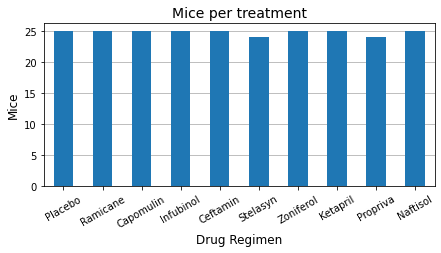

In [10]:
#Put placebo results first
ordered_drugs = ['Placebo','Ramicane', 'Capomulin', 'Infubinol',  'Ceftamin', 'Stelasyn', 'Zoniferol', 'Ketapril', 'Propriva', 'Naftisol']
order = pd.api.types.CategoricalDtype(categories=ordered_drugs, ordered=True)
mouse_study_clean_df['Drug_Regimen'] = mouse_study_clean_df['Drug_Regimen'].astype(order)

drug_only_group = mouse_study_clean_df.groupby(['Drug_Regimen'])

count_unique_mice = drug_only_group['Mouse_ID'].nunique()

ax=count_unique_mice.plot(kind="bar", figsize=(7,3), legend=False, rot=30, zorder=3)

ax.set_ylabel("Mice", size=12)
ax.set_xlabel("Drug Regimen", size=12)
ax.set_title("Mice per treatment", size=14)
ax.grid(axis='y', zorder=0)
plt.draw()

Use Pyplot to generate a bar plot showing the total number of mice treatment in each treatment regimen throughout 
the course of the study.

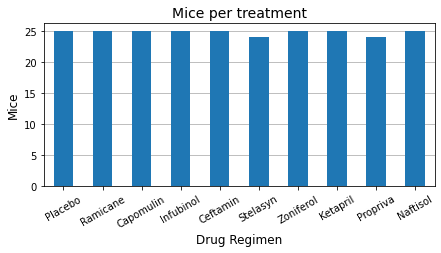

In [11]:
#Put placebo results first
ordered_drugs = ['Placebo','Ramicane', 'Capomulin', 'Infubinol',  'Ceftamin', 'Stelasyn', 'Zoniferol', 'Ketapril', 'Propriva', 'Naftisol']
order = pd.api.types.CategoricalDtype(categories=ordered_drugs, ordered=True)
mouse_study_clean_df.loc['Drug_Regimen'] = mouse_study_clean_df['Drug_Regimen'].astype(order)

drug_only_group = mouse_study_clean_df.groupby(['Drug_Regimen'])

count_unique_mice = drug_only_group['Mouse_ID'].nunique()

count_chart = count_unique_mice.plot(kind='bar', figsize=(7,3), rot=30, zorder=3)
plt.title("Mice per treatment", size=14)
plt.ylabel("Mice", size=12)
plt.xlabel("Drug Regimen", size=12)
plt.grid(axis='y', zorder=0)
plt.show()

In [12]:
#"Duplicate" mouse was removed from Propiva group, what's with Stelasyn? Nothing obvious to me in data,
#probably have to ask the researchers.
Propriva_group = mouse_study_df.loc[mouse_study_df['Drug_Regimen'] == "Stelasyn"]
Propriva_group_sorted = Propriva_group.sort_values(["Mouse_ID","Timepoint"])
pd.set_option('display.max_rows', 1000)
Propriva_group_sorted

,Mouse_ID,Drug_Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor_Volume_mm3,Metastatic Sites
494,a366,Stelasyn,Female,16,29,0,45.000000,0
495,a366,Stelasyn,Female,16,29,5,48.951368,0
496,a366,Stelasyn,Female,16,29,10,53.523990,0
497,a366,Stelasyn,Female,16,29,15,55.265582,0
498,a366,Stelasyn,Female,16,29,20,57.285987,0
499,a366,Stelasyn,Female,16,29,25,59.011728,0
500,a366,Stelasyn,Female,16,29,30,63.440686,1
514,a492,Stelasyn,Male,20,25,0,45.000000,0
515,a492,Stelasyn,Male,20,25,5,46.409143,0
516,a492,Stelasyn,Male,20,25,10,48.432197,0


Here are a couple of charts I made having interpreted "throughout the study" as "over the time course".
Too pretty to discard.

In real life I would probably make more user-friendly x-axes, couldn't yet find a pandas method
that worked the way I wanted (and now see I don't have to).

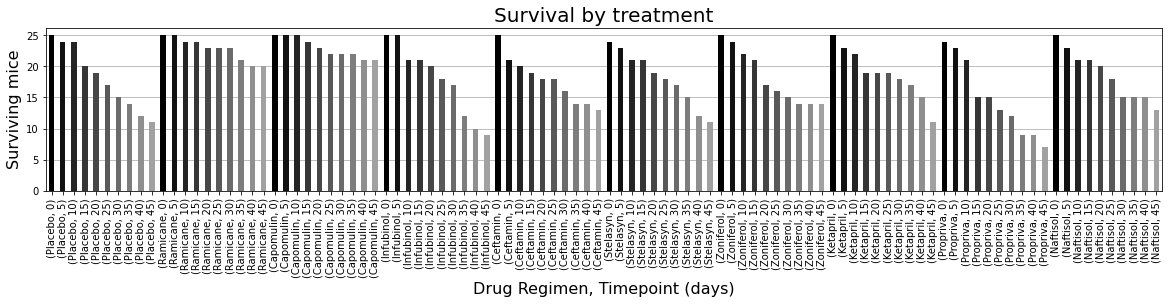

In [13]:
#https://stackoverflow.com/questions/39275294/sort-by-certain-order-situation-pandas-dataframe-groupby

#Put placebo results first
ordered_drugs = ['Placebo','Ramicane', 'Capomulin', 'Infubinol',  'Ceftamin', 'Stelasyn', 'Zoniferol', 'Ketapril', 'Propriva', 'Naftisol']
order = pd.api.types.CategoricalDtype(categories=ordered_drugs, ordered=True)
mouse_study_clean_df['Drug_Regimen'] = mouse_study_clean_df['Drug_Regimen'].astype(order)

drug_group = mouse_study_clean_df.groupby(['Drug_Regimen', 'Timepoint'])

count_mice = drug_group['Mouse_ID'].count()

my_colors = list(islice(cycle(['0', '.07', '0.14', '0.21', '0.28', '0.35', '0.42', '0.49', '0.56', '0.63']), None, len(drug_group)))

ax=count_mice.plot(kind="bar", figsize=(20,3), legend=False, title="Survival by treatment", color=my_colors, zorder=3)

ax.set_ylabel("Surviving mice", size=16)
ax.set_xlabel("Drug Regimen, Timepoint (days)", size=16)
ax.set_title("Survival by treatment", size=20)
ax.grid(axis='y', zorder=0)

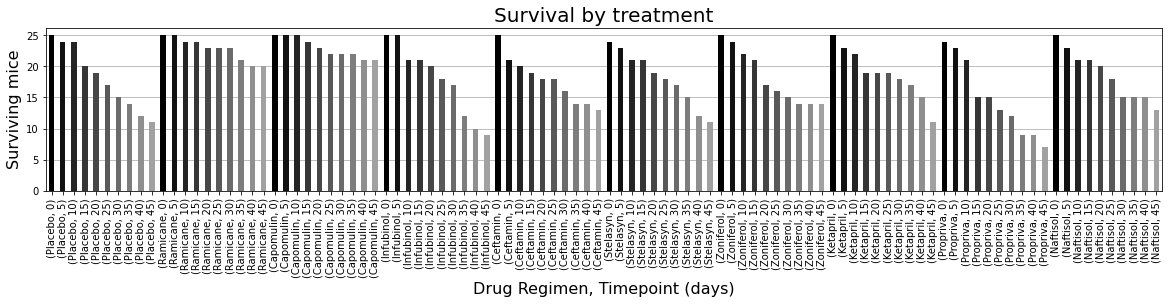

In [14]:
#Put placebo results first
ordered_drugs = ['Placebo','Ramicane', 'Capomulin', 'Infubinol',  'Ceftamin', 'Stelasyn', 'Zoniferol', 'Ketapril', 'Propriva', 'Naftisol']
order = pd.api.types.CategoricalDtype(categories=ordered_drugs, ordered=True)
mouse_study_clean_df.loc['Drug_Regimen'] = mouse_study_clean_df['Drug_Regimen'].astype(order)

drug_group = mouse_study_clean_df.groupby(['Drug_Regimen', 'Timepoint'])

count_mice = drug_group['Mouse_ID'].count()

colors = '0', '.07', '0.14', '0.21', '0.28', '0.35', '0.42', '0.49', '0.56', '0.63'

count_chart = count_mice.plot(kind='bar', color=colors, figsize=(20,3), zorder=3)
plt.title("Survival by treatment", size=20)
plt.ylabel("Surviving mice", size=16)
plt.xlabel("Drug Regimen, Timepoint (days)", size=16)
plt.grid(axis='y', zorder=0)
plt.show()

Generate a pie plot using Pandas's `DataFrame.plot()` that shows the distribution of female or male mice in the study.

Text(0.5, 1.0, 'Mice by sex')

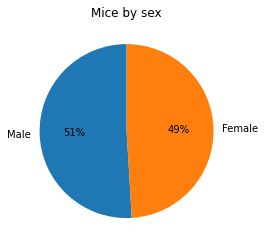

In [15]:
ax=mouse_study_clean_df['Sex'].value_counts().plot.pie(startangle=90, autopct='%1.0f%%', label='')
ax.set_title("Mice by sex")

Generate a pie plot showing the distribution of female versus male mice using pyplot.

<function matplotlib.pyplot.show(*args, **kw)>

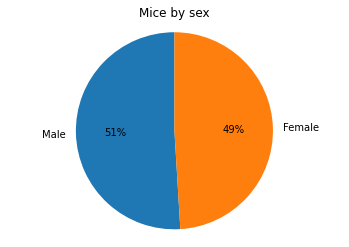

In [16]:
labels="Male", "Female"
plt.pie(mouse_study_clean_df['Sex'].value_counts(), labels=labels, autopct='%1.0f%%', startangle=90)
plt.title("Mice by sex")
plt.axis('equal')
plt.show

## Quartiles, Outliers and Boxplots

Calculate the final tumor volume of each mouse across four of the most promising treatment regimens: Capomulin, 
Ramicane, Infubinol, and Ceftamin. 

In [17]:
#https://stackoverflow.com/questions/23394476/keep-other-columns-when-doing-groupby

mouse_study_clean_df_by_drug =  mouse_study_clean_df.set_index('Drug_Regimen')
mouse_study_clean_best_drugs = mouse_study_clean_df_by_drug.drop(index=['Placebo','Stelasyn', 'Zoniferol', 'Ketapril', 'Propriva', 'Naftisol'])
mouse_study_clean_best_drugs_no_na = mouse_study_clean_best_drugs.dropna()
mouse_study_clean_best_drugs_no_na.reset_index(inplace=True)
final_timepoints_grouped = mouse_study_clean_best_drugs_no_na.sort_values("Timepoint").groupby(['Drug_Regimen','Mouse_ID'], as_index=False).last().dropna()
final_timepoints_grouped["Metastatic Sites"] = final_timepoints_grouped["Metastatic Sites"].astype(int)

pd.set_option('display.max_rows', 1000)
final_timepoints_grouped
#final_timepoints_grouped.dtypes

#final_timepoints_index_reset = final_timepoints_grouped.reset_index()
#final_timepoints_index_reset

#As far as I can tell there are none of the unwanted treatments in this dataframe, and yet
#the boxplots are giving trouble... Here's one test, results are all "False"

#c1 = ['Placebo','Stelasyn','Zoniferol','Ketapril','Propriva','Naftisol']
#final_timepoints_grouped['Drug_Regimen'].isin(c1)

#c1 = ['Placebo','Stelasyn','Zoniferol','Ketapril','Propriva','Naftisol']
#final_timepoints_index_reset['Drug_Regimen'].isin(c1)

#FINALLY found an answer that works, although I can't say I see why. Applied for box plots (below).

#https://stackoverflow.com/questions/39380389/hoy-can-i-plot-a-group-by-boxplot-in-pandas-dropping-unused-categories


,Drug_Regimen,Mouse_ID,Sex,Age_months,Weight (g),Timepoint,Tumor_Volume_mm3,Metastatic Sites
103,Ramicane,a411,Male,3.0,22.0,45.0,38.407618,1
104,Ramicane,a444,Female,10.0,25.0,45.0,43.047543,0
105,Ramicane,a520,Male,13.0,21.0,45.0,38.810366,1
107,Ramicane,a644,Female,7.0,17.0,45.0,32.978522,1
116,Ramicane,c458,Female,23.0,20.0,30.0,38.342008,2
117,Ramicane,c758,Male,9.0,17.0,45.0,33.397653,1
119,Ramicane,d251,Female,8.0,19.0,45.0,37.311236,2
121,Ramicane,e662,Male,8.0,24.0,45.0,40.659006,2
127,Ramicane,g791,Male,11.0,16.0,45.0,29.128472,1
129,Ramicane,i177,Male,10.0,18.0,45.0,33.562402,3


Calculate the quartiles and IQR and quantitatively determine if there are any potential outliers across 
all four treatment regimens.

Answer: One outlier (barely) in Infubinol mininum volume.

In [18]:

#best_drugs_final_timepoints_df = best_drugs_final_timepoints_df[best_drugs_final_timepoints_df["Drug_Regimen"].isin(['Capomulin','Ramicane','Infubinol','Ceftamin'])]
Lower_quartile = final_timepoints_grouped.groupby("Drug_Regimen")['Tumor_Volume_mm3'].quantile([.25])
Median = final_timepoints_grouped.groupby("Drug_Regimen")['Tumor_Volume_mm3'].quantile([.5])
Upper_quartile = final_timepoints_grouped.groupby("Drug_Regimen")['Tumor_Volume_mm3'].quantile([.75])

quartiles_df=pd.merge(Lower_quartile, Median, on="Drug_Regimen")
quartiles_df = quartiles_df.rename(columns = {"Tumor_Volume_mm3_x":"Lower_quartile", "Tumor_Volume_mm3_y":"Median"})
quartiles_df=pd.merge(quartiles_df, Upper_quartile, on="Drug_Regimen")
quartiles_df = quartiles_df.rename(columns = {"Tumor_Volume_mm3":"Upper_quartile"})

quartiles_df["IQR"] = quartiles_df["Upper_quartile"] - quartiles_df["Lower_quartile"]

quartiles_df["Lower_bound"] = quartiles_df["Lower_quartile"] - (1.5*quartiles_df["IQR"])
quartiles_df["Upper_bound"] = quartiles_df["Upper_quartile"] + (1.5*quartiles_df["IQR"])

quartiles_df["Min_volume"] = final_timepoints_grouped.groupby("Drug_Regimen")['Tumor_Volume_mm3'].min()
quartiles_df["Max_volume"] = final_timepoints_grouped.groupby("Drug_Regimen")['Tumor_Volume_mm3'].max()

#For some reason there were rows of NaN values showing up for the unwanted treatments, although as far as I 
#can see they aren't in the source file final_timepoints_grouped (see previous cell). Finally gave up and 
#deleted them:

#quartiles_df
quartiles_no_NaN = quartiles_df.dropna()
quartiles_no_NaN

# Tried to highlight the outlier in the table by applying conditions, but attempts at even really simple highlighting
# gave "AttributeError: 'Styler' object has no attribute 'style'". Decided it was unimportant for now.



,Lower_quartile,Median,Upper_quartile,IQR,Lower_bound,Upper_bound,Min_volume,Max_volume
Drug_Regimen,,,,,,,,
Ramicane,31.560470,36.561652,40.659006,9.098537,17.912664,54.306811,22.050126,45.220869
Capomulin,32.377357,38.125164,40.159220,7.781863,20.704562,51.832015,23.343598,47.685963
Infubinol,54.048608,60.165180,65.525743,11.477135,36.832905,82.741446,36.321346,72.226731
Ceftamin,48.722078,59.851956,64.299830,15.577752,25.355450,87.666458,45.000000,68.923185


Using Matplotlib, generate a box and whisker plot of the final tumor volume for all four treatment regimens 
and highlight any potential outliers in the plot by changing their color and style.

Extra special data cleanup for box plots.

In [19]:
#https://stackoverflow.com/questions/39380389/hoy-can-i-plot-a-group-by-boxplot-in-pandas-dropping-unused-categories

final_timepoints_grouped["Drug_Regimen2"] = pd.Categorical(final_timepoints_grouped["Drug_Regimen"], list(['Ramicane', 'Capomulin', 'Infubinol', 'Ceftamin']))

final_timepoints_grouped

,Drug_Regimen,Mouse_ID,Sex,Age_months,Weight (g),Timepoint,Tumor_Volume_mm3,Metastatic Sites,Drug_Regimen2
103,Ramicane,a411,Male,3.0,22.0,45.0,38.407618,1,Ramicane
104,Ramicane,a444,Female,10.0,25.0,45.0,43.047543,0,Ramicane
105,Ramicane,a520,Male,13.0,21.0,45.0,38.810366,1,Ramicane
107,Ramicane,a644,Female,7.0,17.0,45.0,32.978522,1,Ramicane
116,Ramicane,c458,Female,23.0,20.0,30.0,38.342008,2,Ramicane
117,Ramicane,c758,Male,9.0,17.0,45.0,33.397653,1,Ramicane
119,Ramicane,d251,Female,8.0,19.0,45.0,37.311236,2,Ramicane
121,Ramicane,e662,Male,8.0,24.0,45.0,40.659006,2,Ramicane
127,Ramicane,g791,Male,11.0,16.0,45.0,29.128472,1,Ramicane
129,Ramicane,i177,Male,10.0,18.0,45.0,33.562402,3,Ramicane


Matplotlib version

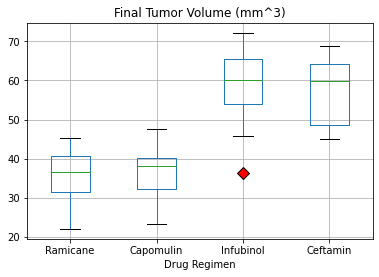

In [20]:
red_diamond = dict(markerfacecolor='r', marker='D', markersize=8)
ax = final_timepoints_grouped.boxplot(column=["Tumor_Volume_mm3"], by="Drug_Regimen2", flierprops=red_diamond)
plt.suptitle("")
ax.set_xlabel("Drug Regimen")
ax.set_title("Final Tumor Volume (mm^3)")
plt.show() 

Seaborn version - better default axis labeling IMHO, and a simple option for showing all the 
data (my preference) without having to merge plots or some ugly thing.

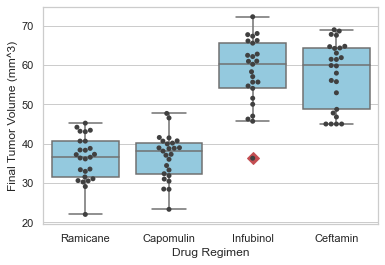

In [21]:
#https://seaborn.pydata.org/generated/seaborn.boxplot.html

red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='D', markersize=8)
sns.set(style="whitegrid")
ax = sns.boxplot(x='Drug_Regimen2',y='Tumor_Volume_mm3',color="skyblue", data=final_timepoints_grouped,flierprops=red_square)
ax = sns.swarmplot(x='Drug_Regimen2',y='Tumor_Volume_mm3',data=final_timepoints_grouped, color=".25")

ax.set_xlabel("Drug Regimen")
ax.set_ylabel("Final Tumor Volume (mm^3)")
plt.show()

This is a pandas version...

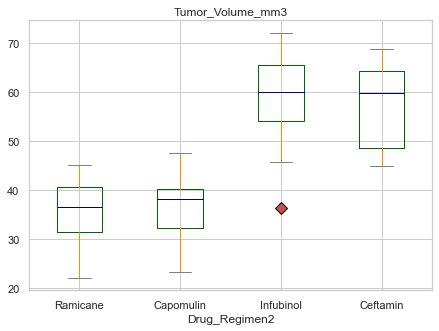

In [22]:
#https://stackoverflow.com/questions/39297093/change-the-facecolor-of-boxplot-in-pandas
#(doesn't work exactly as in the example... but anyway does change some colors)

red_diamond = dict(markerfacecolor='r', marker='D', markersize=8)
props = dict(boxes="DarkGreen", whiskers="DarkOrange", medians="DarkBlue", caps="Gray")
tumor_size_boxplot = final_timepoints_grouped.boxplot(column="Tumor_Volume_mm3", by="Drug_Regimen2", flierprops=red_diamond, figsize=(7, 5), color=props)
plt.suptitle('') 
plt.show()

## Line and Scatter Plots

Select a mouse that was treated with Capomulin and generate a line plot of tumor volume vs. timepoint for that mouse.

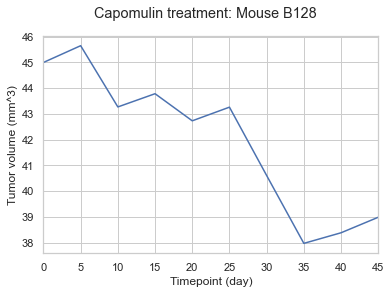

In [38]:
Mouse_b128_df = mouse_study_clean_df.loc[mouse_study_clean_df['Mouse_ID'] == "b128"]
#Mouse_b128_df_sorted = Mouse_b128_df.sort_values(by=["Timepoint","Tumor_Volume_mm3"])
#plot = plt.line(x=Mouse_b128_df["Timepoint"], y=Mouse_b128_df["Tumor_Volume_mm3"])
Mouse_b128_df_sorted = Mouse_b128_df.sort_values(["Timepoint", "Tumor_Volume_mm3"])


plot = plt.plot(Mouse_b128_df_sorted["Timepoint"], Mouse_b128_df_sorted["Tumor_Volume_mm3"])
plt.xlabel('Timepoint (day)', size=12)
plt.ylabel('Tumor volume (mm^3)', size=12)
plt.suptitle('Capomulin treatment: Mouse B128')
plt.xlim(0,45)
plt.show()




Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin treatment regimen.

/Users/bmacgreg/opt/anaconda3/envs/NewPythonData/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


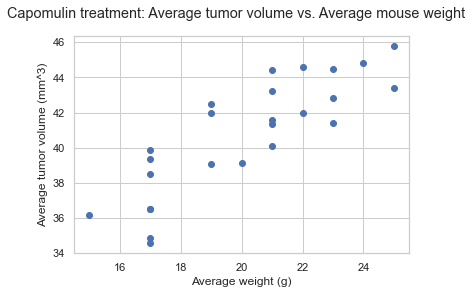

In [39]:
Capomulin_df = mouse_study_clean_df.loc[mouse_study_clean_df['Drug_Regimen'] == 'Capomulin']

Capomulin_df.loc[:, "Age_months"] = pd.to_numeric(Capomulin_df.loc[:, "Age_months"])
Capomulin_df.loc[:,"Weight (g)"] = pd.to_numeric(Capomulin_df.loc[:, "Weight (g)"])
Capomulin_df.loc[:,"Timepoint"] = pd.to_numeric(Capomulin_df.loc[:, "Timepoint"])
Capomulin_df.loc[:,"Tumor_Volume_mm3"] = pd.to_numeric(Capomulin_df.loc[:, "Tumor_Volume_mm3"])
Capomulin_df.loc[:,"Metastatic Sites"] = pd.to_numeric(Capomulin_df.loc[:,"Metastatic Sites"])

Capomulin_by_mouse = Capomulin_df.groupby("Mouse_ID")

mean_tumor_volume = Capomulin_by_mouse["Tumor_Volume_mm3"].mean()

mean_mouse_weight = Capomulin_by_mouse["Weight (g)"].mean()

Capomulin_tumor_vol_mouse_weight = pd.merge(mean_mouse_weight, mean_tumor_volume, on=["Mouse_ID"])

plot = plt.scatter(Capomulin_tumor_vol_mouse_weight["Weight (g)"], Capomulin_tumor_vol_mouse_weight["Tumor_Volume_mm3"])
plt.xlabel('Average weight (g)', size=12)
plt.ylabel('Average tumor volume (mm^3)', size=12)
plt.suptitle('Capomulin treatment: Average tumor volume vs. Average mouse weight')
plt.show()

Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen.

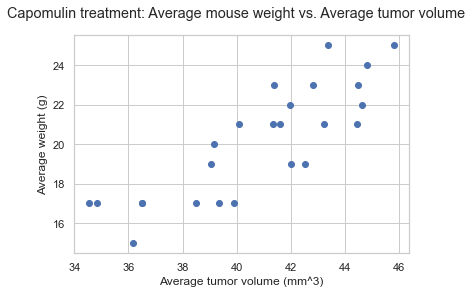

In [40]:
plot = plt.scatter(Capomulin_tumor_vol_mouse_weight["Tumor_Volume_mm3"], Capomulin_tumor_vol_mouse_weight["Weight (g)"])
plt.ylabel('Average weight (g)', size=12)
plt.xlabel('Average tumor volume (mm^3)', size=12)
plt.suptitle('Capomulin treatment: Average mouse weight vs. Average tumor volume')
plt.show()

## Correlation and Regression

Calculate the correlation coefficient and linear regression model between mouse weight and 
average tumor volume for the Capomulin treatment. 

In [41]:
#Capomulin_tumor_vol_mouse_weight

Average_mouse_weight = Capomulin_tumor_vol_mouse_weight.iloc[:,0]
Average_tumor_volume = Capomulin_tumor_vol_mouse_weight.iloc[:,1]
correlation = st.pearsonr(Average_mouse_weight,Average_tumor_volume)
print(f"The correlation between average mouse weight and average tumor volume is {round(correlation[0],2)}")

The correlation between average mouse weight and average tumor volume is 0.84


Calculate the linear regression model between mouse weight and average tumor volume 
for the Capomulin treatment. Plot the linear regression model on top of the previous scatter plot.

The r-squared is: 0.7088568047708723


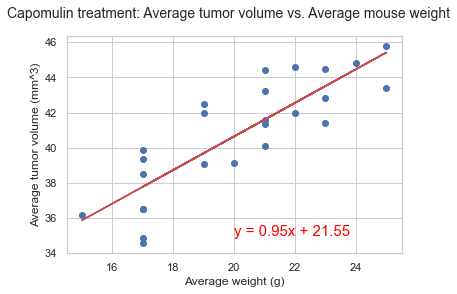

In [42]:
x_values = Capomulin_tumor_vol_mouse_weight["Weight (g)"]
y_values = Capomulin_tumor_vol_mouse_weight["Tumor_Volume_mm3"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,35),fontsize=15,color="red")
plt.xlabel('Average weight (g)', size=12)
plt.ylabel('Average tumor volume (mm^3)', size=12)
plt.suptitle('Capomulin treatment: Average tumor volume vs. Average mouse weight', size=14)
print(f"The r-squared is: {rvalue**2}")
plt.show()